# Imports

In [12]:
# %% Cell 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler


# Data Loading Function

    Load CSV data with the specified delimiter.
    Prints detected columns for verification.
    Returns the loaded DataFrame, or None if there's an error.

In [13]:
# %% Cell 2: Data Loading Function
def load_data(filename, sep=','):
    try:
        data = pd.read_csv(filename, sep=sep)
        print(f"{filename} - Detected columns:", data.columns.tolist())
        return data
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None


# Data Processing Function

 
    Extracts and preprocesses the required columns, ensuring numerical consistency.
    Scales the spatial features (Latitude & Longitude) using StandardScaler.
    Returns (X_scaled, y, scaler).
    


In [14]:
# %% Cell 3: Data Preprocessing Function
def preprocess_data(data, variable_name):
    required_columns = ['Latitude', 'Longitude', variable_name]
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")

    data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')
    data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')
    data[variable_name] = pd.to_numeric(data[variable_name], errors='coerce')

    valid_data = data.dropna(subset=['Latitude', 'Longitude', variable_name])

    if len(valid_data) == 0:
        return np.empty((0, 2)), np.array([]), None

    X = valid_data[['Latitude', 'Longitude']].values
    y = valid_data[variable_name].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Processing {variable_name} - Valid Data Points: {len(X_scaled)}")
    return X_scaled, y, scaler


# Create Prediction Grid
    Creates a prediction grid over the scaled spatial extent of X_scaled.
    Returns (lat_mesh, lon_mesh, grid_points_scaled).


In [15]:
# %% Cell 4: Create Prediction Grid
def create_grid(X_scaled, scaler, grid_size=150, padding=0.01):
    
    if len(X_scaled) == 0:
        return None, None, None

    lat_min, lat_max = X_scaled[:, 0].min(), X_scaled[:, 0].max()
    lon_min, lon_max = X_scaled[:, 1].min(), X_scaled[:, 1].max()

    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min

    lat_min -= padding * lat_range
    lat_max += padding * lat_range
    lon_min -= padding * lon_range
    lon_max += padding * lon_range

    lat_grid = np.linspace(lat_min, lat_max, grid_size)
    lon_grid = np.linspace(lon_min, lon_max, grid_size)

    lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

    grid_points = np.vstack([lat_mesh.ravel(), lon_mesh.ravel()]).T
    grid_points_scaled = grid_points

    return lat_mesh, lon_mesh, grid_points_scaled


# Fit Gaussian Process with Hyperparameter Tuning


    Fit a Gaussian Process using a Matern kernel multiplied by a Constant kernel.
    Allows tuning of hyperparameters by passing parameters directly.
    Prints the optimized kernel and computes the covariance matrix for diagnostic purposes.
    Returns the fitted GP model and the covariance matrix on the training data.
    

In [16]:
# %% Cell 5: Fit Gaussian Process with Hyperparameter Tuning
def fit_gaussian_process(X, y, constant_value=1.0, constant_bounds=(1e-3, 1e4),
                           length_scale=1.0, length_scale_bounds=(1e-7, 1e5),
                           nu=1.5, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True):
    kernel = ConstantKernel(constant_value, constant_bounds) * Matern(
        length_scale=length_scale, nu=nu, length_scale_bounds=length_scale_bounds
    )

    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=n_restarts_optimizer,
        alpha=alpha,
        normalize_y=normalize_y
    )
    gp.fit(X, y)
    print("Optimized Kernel:", gp.kernel_)
    cov_matrix = gp.kernel_(X)
    print("Covariance Matrix of Training Data (shape {}):".format(cov_matrix.shape))
    print(cov_matrix if cov_matrix.shape[0] < 10 else "Matrix too large to display fully; showing top 5 rows:\n", cov_matrix[:5])
    return gp, cov_matrix


# Plot Mean Prediction

    Plot the GP mean prediction (hotspot map) as a smooth gradient.
    

In [17]:
# %% Cell 6: Plot Mean Prediction
def plot_mean_prediction(lat_mesh, lon_mesh, y_pred, variable_name, save_path=None):
    if lat_mesh is None or lon_mesh is None or y_pred is None:
        print("No valid grid for plotting.")
        return

    plt.figure(figsize=(12,10))
    heatmap = plt.contourf(lon_mesh, lat_mesh, y_pred, levels=100, cmap='coolwarm')
    plt.xlabel('Longitude', fontsize=16)
    plt.ylabel('Latitude', fontsize=16)
    plt.title(f'Hotspot Map ({variable_name})', fontsize=20)

    cbar = plt.colorbar(heatmap)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(variable_name, fontsize=16)

    if save_path:
        plt.savefig(save_path, dpi=600)
        print(f"Saved mean prediction image: {save_path}")

    plt.show()


# Plot Uncertainty

    Plot the GP uncertainty (standard deviation) as a smooth gradient.
    Does NOT plot original data points.
    

In [18]:
# %% Cell 7: Plot Uncertainty
def plot_uncertainty(lat_mesh, lon_mesh, y_std, variable_name, save_path=None):
    
    if lat_mesh is None or lon_mesh is None or y_std is None:
        print("No valid grid for plotting.")
        return

    plt.figure(figsize=(12,10))
    std_map = plt.contourf(lon_mesh, lat_mesh, y_std, levels=100, cmap='viridis')
    plt.xlabel('Longitude', fontsize=16)
    plt.ylabel('Latitude', fontsize=16)
    plt.title(f'Uncertainty Map ({variable_name})', fontsize=20)

    cbar = plt.colorbar(std_map)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Standard Deviation', fontsize=16)

    if save_path:
        plt.savefig(save_path, dpi=600)
        print(f"Saved uncertainty image: {save_path}")

    plt.show()


# Plot Covariance Matrix

    Plot the covariance matrix using a heatmap.
    

In [19]:
# %% Cell 8: Plot Covariance Matrix
def plot_covariance_matrix(cov_matrix, title="Covariance Matrix"):
    if cov_matrix is None:
        print("No covariance matrix to plot.")
        return

    plt.figure(figsize=(8, 6))
    plt.imshow(cov_matrix, interpolation='none', cmap='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Data Point Index', fontsize=14)
    plt.colorbar(label='Covariance Value')
    plt.show()


# Hyperparameter Configuration
    
    Set hyperparameters for the Gaussian Process


In [20]:

# Constant Kernel Parameters
constant_value = 1.0
constant_bounds = (1e-3, 1e4)

# Matern Kernel Parameters
length_scale = 1.0
length_scale_bounds = (1e-7, 1e5)
nu = 1.5  # Common choices: 1.5 or 2.5

# GP Regressor Parameters
n_restarts_optimizer = 10
alpha = 1e-2
normalize_y = True

# Grid Parameters for Prediction
grid_size = 200
padding = 0.08

print("Hyperparameter configuration loaded.")


Hyperparameter configuration loaded.


# File Loading

In [21]:
files = [
    'C:\ASU\Semester 2\space robotics and ai\codeyy\GP\data\dec6.csv', 
]

sensor_variables = [
    'Temperature (°C)',
]

results_folder = "/home/blazar/Codes/GP/results"
os.makedirs(results_folder, exist_ok=True)

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\battu\AppData\Local\Temp\ipykernel_22112\233594148.py:2: SyntaxWarning: invalid escape sequence '\A'
  'C:\ASU\Semester 2\space robotics and ai\codeyy\GP\data\dec6.csv',


# Main Loop

C:\ASU\Semester 2\space robotics and ai\codeyy\GP\data\dec6.csv - Detected columns: ['Time (UTC)', 'Latitude', 'Longitude', 'Depth (Sonar)', 'Temperature (°C)', 'pH', 'Depth (m)', 'Conductivity (uS/cm)', 'Dissolved Oxygen Saturation', 'Dissolved Oxygen Concentration (mg/L)', 'Chlorophyll (ug/L)', 'CDOM (ppb)', 'Turbidity (NTU)']

Processing file: C:\ASU\Semester 2\space robotics and ai\codeyy\GP\data\dec6.csv
Columns available: ['Time (UTC)', 'Latitude', 'Longitude', 'Depth (Sonar)', 'Temperature (°C)', 'pH', 'Depth (m)', 'Conductivity (uS/cm)', 'Dissolved Oxygen Saturation', 'Dissolved Oxygen Concentration (mg/L)', 'Chlorophyll (ug/L)', 'CDOM (ppb)', 'Turbidity (NTU)']

Processing Temperature (°C) for dec6.csv...
Processing Temperature (°C) - Valid Data Points: 3989
Optimized Kernel: 0.785**2 * Matern(length_scale=0.129, nu=1.5)
Covariance Matrix of Training Data (shape (3989, 3989)):
Matrix too large to display fully; showing top 5 rows:
 [[0.6169583  0.61684621 0.61687573 ... 0.4760

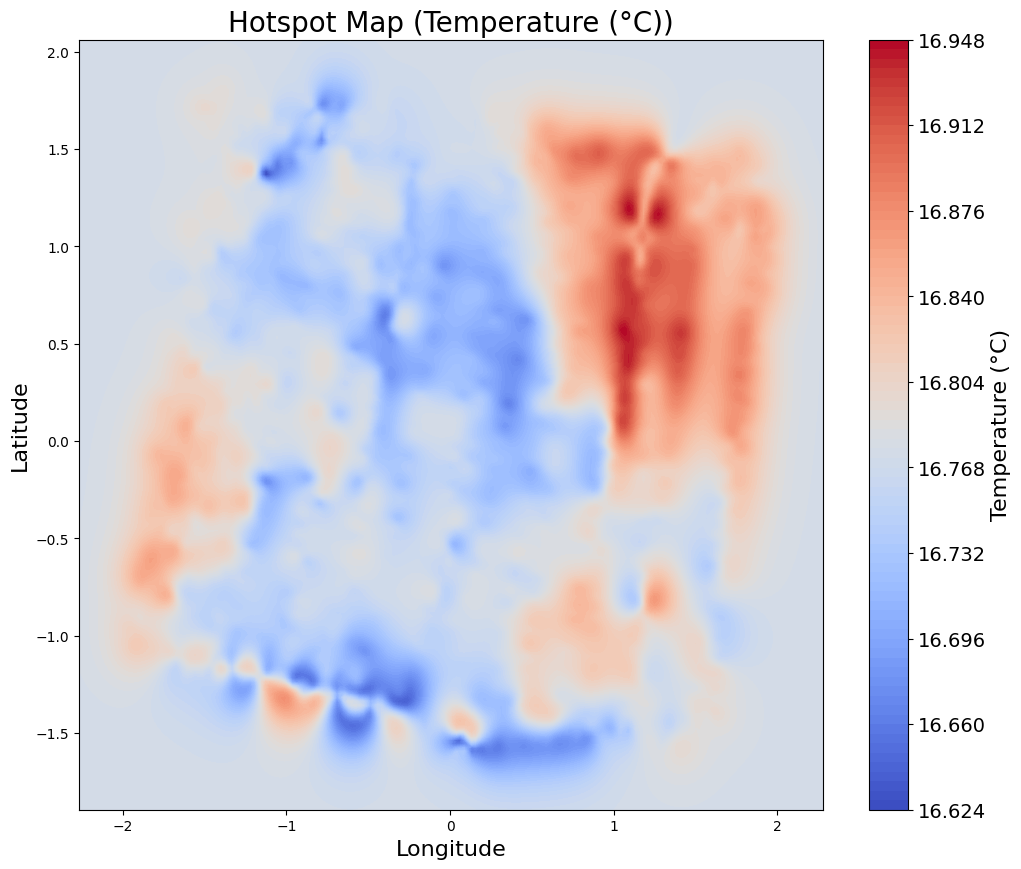

Saved uncertainty image: /home/blazar/Codes/GP/results\dec6\Temperature_°C\std_dec6_Temperature_°C.png


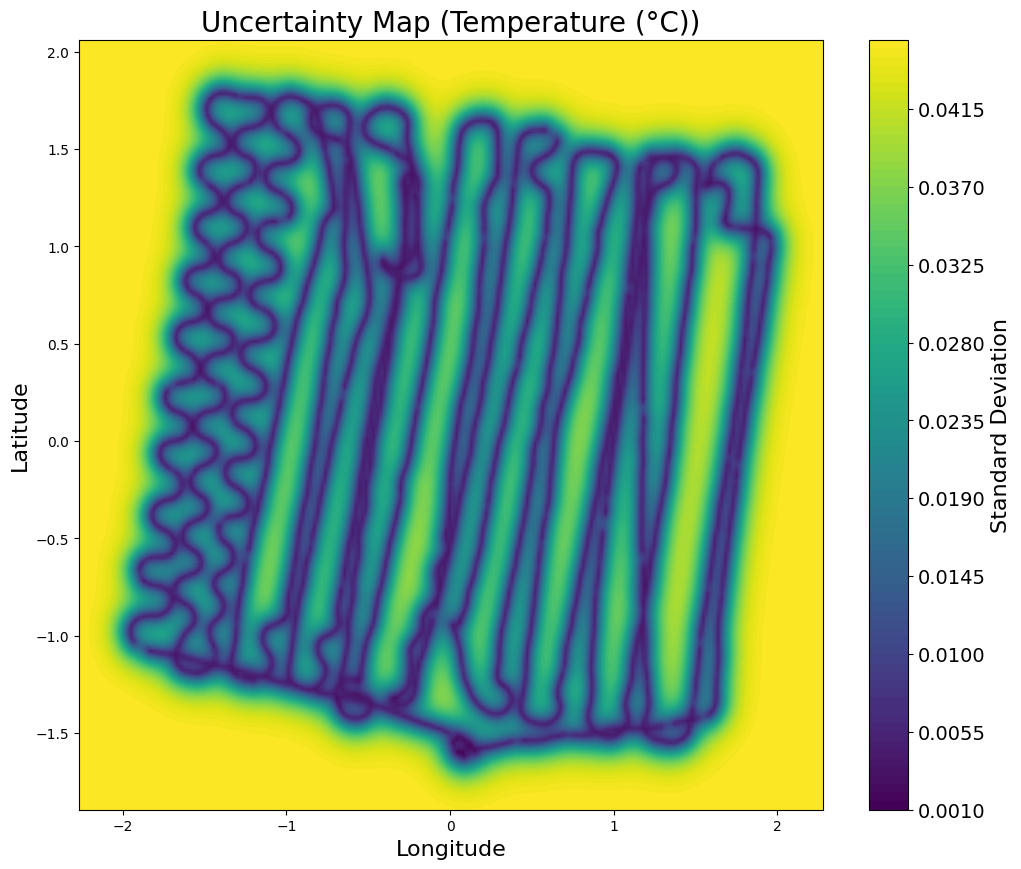

Temperature (°C) GP processed and images saved.

All GP computations for individual files completed successfully.


In [23]:
for file in files:
    data = load_data(file, sep=',')
    if data is None:
        continue

    base_name = os.path.splitext(os.path.basename(file))[0]
    file_folder = os.path.join(results_folder, base_name)
    os.makedirs(file_folder, exist_ok=True)
    
    print(f"\nProcessing file: {file}")
    print("Columns available:", data.columns.tolist())
    
    for variable in sensor_variables:
        if variable not in data.columns:
            print(f"-> Variable {variable} not found in {base_name}.csv. Skipping.")
            continue
        
        try:
            print(f"\nProcessing {variable} for {base_name}.csv...")
            X_scaled, y, scaler = preprocess_data(data, variable)

            if len(y) == 0:
                print(f"⚠️ No valid data for {variable} in {base_name}.csv, skipping.")
                continue

            lat_mesh, lon_mesh, grid_points_scaled = create_grid(X_scaled, scaler, grid_size=grid_size, padding=padding)
            if grid_points_scaled is None:
                print("⚠️ No valid grid could be created. Skipping.")
                continue

            gp_model, cov_matrix_train = fit_gaussian_process(
                X_scaled, y,
                constant_value=constant_value,
                constant_bounds=constant_bounds,
                length_scale=length_scale,
                length_scale_bounds=length_scale_bounds,
                nu=nu,
                n_restarts_optimizer=n_restarts_optimizer,
                alpha=alpha,
                normalize_y=normalize_y
            )

            y_pred, y_std = gp_model.predict(grid_points_scaled, return_std=True)
            y_pred = y_pred.reshape(lat_mesh.shape)
            y_std = y_std.reshape(lat_mesh.shape)

            var_sanitized = (variable.replace(' ', '_')
                                     .replace('(', '')
                                     .replace(')', '')
                                     .replace('/', '_'))

            var_folder = os.path.join(file_folder, var_sanitized)
            os.makedirs(var_folder, exist_ok=True)

            mean_save_path = os.path.join(var_folder, f"mean_{base_name}_{var_sanitized}.png")
            std_save_path = os.path.join(var_folder, f"std_{base_name}_{var_sanitized}.png")

            plot_mean_prediction(lat_mesh, lon_mesh, y_pred, variable_name=variable, save_path=mean_save_path)
            plot_uncertainty(lat_mesh, lon_mesh, y_std, variable_name=variable, save_path=std_save_path)

            print(f"{variable} GP processed and images saved.")

        except Exception as e:
            print(f"error processing {variable} for {base_name}: {e}")

print("\nAll GP computations for individual files completed successfully.")